<h1 style="text-align: center;">Project Notebook</h1>

In [25]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
print(os.getcwd())
%matplotlib inline
import shutil
import pandas as pd
import matplotlib
from torchvision import datasets
from torch.utils.data import DataLoader
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.models as models
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from PIL import Image
from torchvision import transforms
import matplotlib as mpl
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121, DenseNet121_Weights

C:\Users\Georgelele\PycharmProjects\Comp9444Proj1


<h2 style="text-align: center;">Introduction, Motivation and/or Problem Statement</h2>

Place the intro here

<h2 style="text-align: center;">Data Sources or RL Tasks</h2>

place the data source here

<h2 style="text-align: center;">Exploratory Analysis of Data or RL Tasks</h2>

The data provided was not given in a formatting which would allow the data to simply be provided to the neural network, so preprocessing steps must be taken to ensure that the model is able to receive the correct information. First, a pandas dataframe containing the metadata of the provided dataset was extracted, to allow the properties to be efficiently analysed and allow modifications to the dataset to be easily made. This was then transformed to a new folder, which stored a train, test and validation set, ready to be imported by torchvisions datasets module, allowing ease to preparation to be provided to the model. 

Through this analysis, it is found that the dataset provided is grouped by 2 main properties; the class of the image and its magnification. The distribution of the data and its associated classes and magnifications are shown below. It can be seen that there is a vast class imbalance which may result in difficulties in predicting certain classes, particularly those with small samples. 

In [38]:
 # the original dataset
src_root = os.path.join(os.getcwd(), "C:\\Users\\Georgelele\\Downloads\\EBH-HE-IDS\\ColHis-IDS")
# a midway dataset that stores its metadata information in a pandas dataframe
dst_root = os.path.join(os.getcwd(), "grouped_ds")

os.makedirs(dst_root, exist_ok=True)

df = pd.DataFrame()

for class_name in os.listdir(src_root):
    class_path = os.path.join(src_root, class_name)
    for root, dirs, files in os.walk(class_path):
        if len(dirs) == 0:
            magnification = int(list(root.split('\\'))[-1])
            instance = list(root.split('\\'))[-2]

            for i in range(len(files)):
                file_name = f'{class_name}_{magnification}_{instance}_{i}.jpg'
                data = pd.DataFrame([{
                    'class': class_name,
                    'magnification': magnification,
                    'file name': file_name
                }])
                df = pd.concat([df, data]).reset_index(drop=True)

                src_file = os.path.join(root, files[i])
                dst_file = os.path.join(dst_root, file_name)
                shutil.copy2(src_file, dst_file)

df.to_csv('metadata.csv')

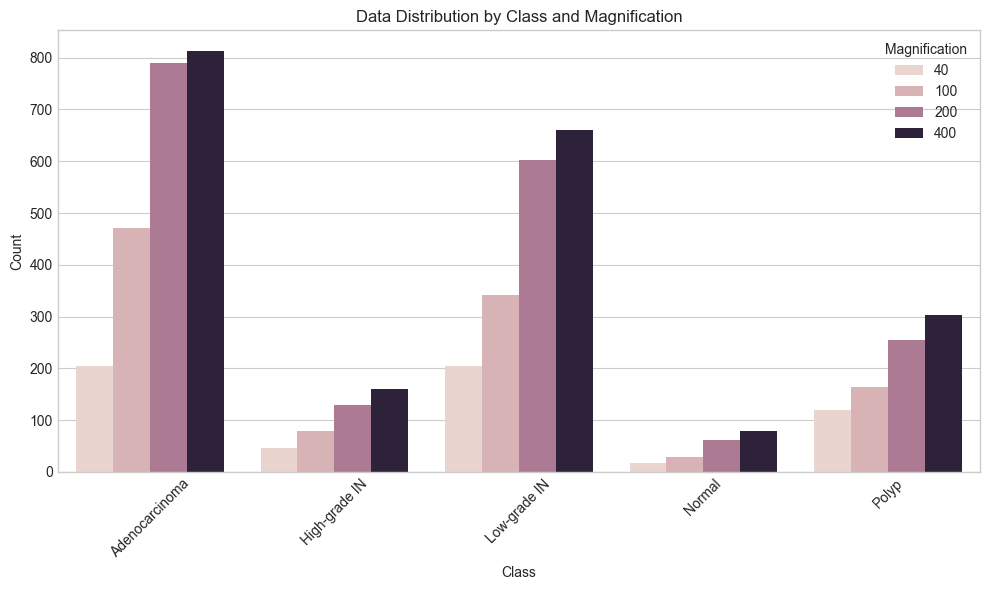

In [39]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="class", hue="magnification")
plt.title("Data Distribution by Class and Magnification")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend(title="Magnification")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
src_root = os.path.join(os.getcwd(), "grouped_ds")
dst_root = os.path.join(os.getcwd(), "datasetrebased")

df = pd.read_csv("metadata.csv")

# can manipulate data below if needed - change the class distribution etc
# split dataset into train, val, test sets (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

splits = {
    'train': train_df,
    'val': val_df,
    'test': test_df
}

for split_name, split_df in splits.items():
    for class_name in np.unique(split_df['class']):
        class_data = split_df[split_df['class'] == class_name]

        class_folder = os.path.join(dst_root, split_name, class_name)
        os.makedirs(class_folder, exist_ok=True)

        for file_name in class_data['file name'].values:
            src_file = os.path.join(src_root, file_name)
            dst_file = os.path.join(class_folder, file_name)
            shutil.copy2(src_file, dst_file)

In [41]:
df

,Unnamed: 0,class,magnification,file name
0,0,Adenocarcinoma,100,Adenocarcinoma_100_20201113-2013084-1_0.jpg
1,1,Adenocarcinoma,100,Adenocarcinoma_100_20201113-2013084-1_1.jpg
2,2,Adenocarcinoma,100,Adenocarcinoma_100_20201113-2013084-1_2.jpg
3,3,Adenocarcinoma,100,Adenocarcinoma_100_20201113-2013084-1_3.jpg
4,4,Adenocarcinoma,100,Adenocarcinoma_100_20201113-2013084-1_4.jpg
...,...,...,...,...
5527,5527,Polyp,200,Polyp_200_20210711-XC2015381-1_2.jpg
5528,5528,Polyp,200,Polyp_200_20210711-XC2015381-1_3.jpg
5529,5529,Polyp,400,Polyp_400_20210711-XC2015381-1_0.jpg
5530,5530,Polyp,400,Polyp_400_20210711-XC2015381-1_1.jpg


Loss Function selection based on the dataset

loss function

In [54]:
# -----------------------------
# Loss functions
# -----------------------------
def dice_loss(pred, target, epsilon=1e-6):
    pred = torch.softmax(pred, dim=1)
    target = F.one_hot(target, num_classes=pred.size(1)).permute(0, 3, 1, 2).float() \
        if target.ndim == 3 else F.one_hot(target, num_classes=pred.size(1)).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - (2. * intersection + epsilon) / (union + epsilon)

def focal_loss(pred, target, alpha=0.75, gamma=2):
    ce_loss = F.cross_entropy(pred, target, reduction='none')
    pt = torch.exp(-ce_loss)
    focal = alpha * (1 - pt) ** gamma * ce_loss
    return focal.mean()

def tversky_loss(pred, target, alpha=0.7, beta=0.3, epsilon=1e-6):
    pred = torch.softmax(pred, dim=1)
    target = F.one_hot(target, num_classes=pred.size(1)).float()
    tp = (pred * target).sum()
    fp = ((1 - target) * pred).sum()
    fn = (target * (1 - pred)).sum()
    return 1 - (tp + epsilon) / (tp + alpha * fp + beta * fn + epsilon)

def combo_loss(pred, target):
    return 0.5 * focal_loss(pred, target) + 0.5 * dice_loss(pred, target)

def focal_tversky_combo(pred, target):
    return 0.5 * focal_loss(pred, target) + 0.5 * tversky_loss(pred, target)

def select_loss(loss_type):
    if loss_type == "dice":
        return dice_loss
    elif loss_type == "focal":
        return focal_loss
    elif loss_type == "tversky":
        return tversky_loss
    elif loss_type == "focal+dice":
        return combo_loss
    elif loss_type == "focal+tversky":
        return focal_tversky_combo
    else:
        raise ValueError(f"Unsupported loss function: {loss_type}")


<h2 style="text-align: center;">Models and Methods</h2>

Overview of Model + Model Choices

resnet50

In [84]:
# -----------------------------
# resnet50
# -----------------------------
def get_resnet_classifier(num_classes=5, pretrained=True):
    model = models.resnet50(weights="IMAGENET1K_V1" if pretrained else None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

Densenet

In [56]:
def get_densenet_classifier(num_classes=5, pretrained=True):
    weights = DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
    model = densenet121(weights=weights)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
    return model

EfficientNet

In [57]:
def get_efficientnet_classifier(num_classes=5, pretrained=True):
    weights = EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
    model = efficientnet_b0(weights=weights)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

Metrics Plotting

In [58]:
# -----------------------------
# Metrics Plotting
# -----------------------------
def plot_metrics(history, save_dir=None, show_inline=True):
    epochs = range(1, len(history["acc"]) + 1)
    plt.figure()
    plt.plot(epochs, history["acc"], label="Accuracy")
    plt.plot(epochs, history["precision"], label="Precision")
    plt.plot(epochs, history["recall"], label="Recall")
    plt.plot(epochs, history["f1"], label="F1-score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation Metrics Over Epochs")
    plt.legend()
    plt.grid(True)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, "metrics_curve.png"))
    if show_inline:
        plt.show()
    plt.close()


def plot_per_class_metrics(history, class_names, save_dir=None, show_inline=True):
    epochs = range(1, len(history["acc"]) + 1)

    for metric in ["precision", "recall", "f1"]:
        plt.figure(figsize=(8, 6))
        for i, cls_name in enumerate(class_names):
            plt.plot(epochs, history["per_class"][i][metric], label=cls_name)
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.title(f"Per-Class {metric.capitalize()} Over Epochs")
        plt.legend()
        plt.grid(True)
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f"per_class_{metric}.png"))
        if show_inline:
            plt.show()
        plt.close()


def plot_confusion(y_true, y_pred, class_names, save_dir=None, show_inline=True):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
    if show_inline:
        plt.show()
    plt.close()


Training Loop

In [70]:
# -----------------------------
# Training Loop with Args
# -----------------------------
def train_model(model, train_loader, val_loader, device, args, class_names):
    model = model.to(device)

    # ✅ Select optimizer based on args
    if args.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
    elif args.optimizer == "adamw":
        optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    elif args.optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
    else:
        raise ValueError(f"Unsupported optimizer: {args.optimizer}")

    # ✅ Select loss from args
    loss_fn = select_loss(args.loss)

    history = {
        "acc": [], "precision": [], "recall": [], "f1": [],
        "per_class": {i: {"precision": [], "recall": [], "f1": []} for i in range(len(class_names))}
    }

    best_acc = 0
    best_y_true, best_y_pred = [], []  # ✅ store best predictions

    for epoch in range(args.epochs):
        # -----------------------------
        # Training
        # -----------------------------
        model.train()
        total_loss, correct, total = 0, 0, 0
        pbar = tqdm(train_loader,
            desc=f"Epoch {epoch + 1}/{args.epochs} [Train]",
            unit="batch",
            leave=False)  # ✅ DON'T leave previous bars on screen
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
            pbar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{(correct / total):.4f}"})
    
        train_acc = correct / total
        print(f"[Train] Epoch {epoch+1}: Loss={total_loss/total:.4f}, Acc={train_acc:.4f}")
    
        # -----------------------------
        # Validation
        # -----------------------------
        model.eval()
        y_true, y_pred = [], []
        val_loss, val_correct, val_total = 0, 0, 0
        pbar_val = tqdm(val_loader,
                desc=f"Epoch {epoch + 1}/{args.epochs} [Val]",
                unit="batch",
                leave=False)
        with torch.no_grad():
            for imgs, labels in pbar_val:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = loss_fn(outputs, labels)
    
                preds = outputs.argmax(1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
    
                val_loss += loss.item() * labels.size(0)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
    
                pbar_val.set_postfix({"loss": f"{loss.item():.4f}",
                                      "acc": f"{(val_correct / val_total):.4f}"})
        # -----------------------------
        # Metrics Calculation
        # -----------------------------
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            y_true, y_pred, labels=list(range(len(class_names))), average="macro", zero_division=0
        )
        acc = np.mean(np.array(y_true) == np.array(y_pred))
        history["acc"].append(acc)
        history["precision"].append(precision_macro)
        history["recall"].append(recall_macro)
        history["f1"].append(f1_macro)

        precision_cls, recall_cls, f1_cls, _ = precision_recall_fscore_support(
            y_true, y_pred, labels=list(range(len(class_names))), zero_division=0
        )
        for i, cls_name in enumerate(class_names):
            history["per_class"][i]["precision"].append(precision_cls[i])
            history["per_class"][i]["recall"].append(recall_cls[i])
            history["per_class"][i]["f1"].append(f1_cls[i])
        print(f"[Val]   Epoch {epoch+1}: Acc={acc:.4f}, Precision={precision_macro:.4f}, "
      f"Recall={recall_macro:.4f}, F1={f1_macro:.4f}")

        # ✅ Save best model & predictions
        if acc > best_acc:
            best_acc = acc
            best_y_true = y_true.copy()
            best_y_pred = y_pred.copy()
            os.makedirs(args.save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(args.save_dir, "best_model.pth"))
            print(f"✅ Best model updated at epoch {epoch+1} with Acc={acc:.4f}")

    # -----------------------------
    # Plot results after training
    # -----------------------------
    plot_metrics(history, args.save_dir)
    plot_per_class_metrics(history, class_names)
    plot_confusion("Best Val", best_y_true, best_y_pred, class_names)


Args

In [81]:
import argparse, sys, torch

def get_args():
    parser = argparse.ArgumentParser(description="Train ResNet Classifier on Custom Dataset")
    parser.add_argument("--data_dir", type=str, required=True, help="Path to dataset")
    parser.add_argument("--model", type=str, default="resnet",
                    choices=["resnet", "densenet","efficientnet"],
                    help="Model architecture to use")
    parser.add_argument("--epochs", type=int, default=50, help="Number of training epochs")
    parser.add_argument("--batch_size", type=int, default=16, help="Batch size for training")
    parser.add_argument("--lr", type=float, default=1e-4, help="Learning rate")
    parser.add_argument("--optimizer", type=str, default="adamw", 
                        choices=["adam", "adamw", "sgd"], help="Optimizer type")
    parser.add_argument("--loss", type=str, default="focal+tversky",
                        choices=["dice", "focal", "tversky", "focal+dice", "focal+tversky"],
                        help="Loss function")
    parser.add_argument("--img_size", type=int, default=224, help="Input image size (square)")
    parser.add_argument("--num_workers", type=int, default=4, help="Number of DataLoader workers")
    parser.add_argument("--save_dir", type=str, default="results", help="Directory to save outputs")
    parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu",
                        help="Training device")
    
    args = parser.parse_args(sys.argv[1:])  # works in Jupyter after cleaning sys.argv in launcher
    return args


Plot

In [72]:
# -----------------------------
# Plotting
# -----------------------------
def plot_global(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss Curve
    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy Curve
    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_per_class_metrics(history, class_names):
    epochs = range(1, len(history["acc"]) + 1)

    for metric in ["precision", "recall", "f1"]:
        plt.figure(figsize=(8, 6))
        for i, cls_name in enumerate(class_names):
            plt.plot(epochs, history["per_class"][i][metric], marker='o', label=cls_name)
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.title(f"{metric.capitalize()} Per Class Over Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()  # inline display


def plot_confusion(name, y_true, y_pred, classes, save_dir=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(classes) * 1.2, len(classes) * 1.2))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({name})')
    
    if save_dir:  
        # If a save_dir is provided, optionally save as well
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, f'confusion_{name}.png'))
    
    plt.show()  # Always display inline
    plt.close()


In [73]:
def main():
    args = get_args()

    run_name = f"{args.model}_epochs{args.epochs}_bs{args.batch_size}_lr{args.lr}_loss{args.loss}_img{args.img_size}"
    run_name = run_name.replace("+", "_")  # ✅ sanitize for Windows paths
    args.save_dir = os.path.join(args.save_dir, run_name)
    os.makedirs(args.save_dir, exist_ok=True)

    if not os.path.isdir(args.data_dir):
        raise RuntimeError(f"❌ Dataset path not found: {args.data_dir}")
    print("✅ Using dataset:", args.data_dir)

    transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor(),
    ])

    train_data = datasets.ImageFolder(os.path.join(args.data_dir, "train"), transform=transform)
    val_data   = datasets.ImageFolder(os.path.join(args.data_dir, "val"), transform=transform)

    train_loader = DataLoader(train_data,
                              batch_size=args.batch_size,
                              shuffle=True,
                              num_workers=args.num_workers,
                              pin_memory=True)

    val_loader = DataLoader(val_data,
                            batch_size=args.batch_size,
                            shuffle=False,
                            num_workers=args.num_workers,
                            pin_memory=True)

    class_names = train_data.classes
    print("Classes:", class_names)

    device = torch.device(args.device)
    model_type = args.model.lower()

    if model_type == "resnet":
        model = get_resnet_classifier(num_classes=len(class_names))
    elif model_type == "densenet":
        model = get_densenet_classifier(num_classes=len(class_names))
    elif model_type == "efficientnet":
        model = get_efficientnet_classifier(num_classes=len(class_names))
    else:
        raise ValueError(f"❌ Unsupported model: {model_type}")

    print(f"🧠 Training {model_type.upper()} | Loss: {args.loss}")
    train_model(model, train_loader, val_loader, device, args, class_names)


Launching with: ['--data_dir', 'C:\\Users\\Georgelele\\PycharmProjects\\Comp9444Proj1\\dataset', '--epochs', '30', '--batch_size', '8', '--lr', '5e-4', '--img_size', '512', '--optimizer', 'adamw', '--num_workers', '4', '--save_dir', 'runs', '--loss', 'focal+dice']
✅ Using dataset: C:\Users\Georgelele\PycharmProjects\Comp9444Proj1\dataset
Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
🧠 Training RESNET | Loss: focal+dice


[Train] Epoch 1: Loss=0.3747, Acc=0.7176


[Val]   Epoch 1: Acc=0.7218, Precision=0.4950, Recall=0.5152, F1=0.5013
✅ Best model updated at epoch 1 with Acc=0.7218


[Train] Epoch 2: Loss=0.2965, Acc=0.7723


[Val]   Epoch 2: Acc=0.8364, Precision=0.7876, Recall=0.6367, F1=0.6251
✅ Best model updated at epoch 2 with Acc=0.8364


[Train] Epoch 3: Loss=0.2438, Acc=0.8135


[Val]   Epoch 3: Acc=0.8273, Precision=0.7105, Recall=0.6969, F1=0.6570


[Train] Epoch 4: Loss=0.2192, Acc=0.8320


[Val]   Epoch 4: Acc=0.8764, Precision=0.7763, Recall=0.7276, F1=0.7457
✅ Best model updated at epoch 4 with Acc=0.8764


[Train] Epoch 5: Loss=0.2030, Acc=0.8429


[Val]   Epoch 5: Acc=0.8582, Precision=0.8108, Recall=0.6692, F1=0.6893


[Train] Epoch 6: Loss=0.1778, Acc=0.8664


[Val]   Epoch 6: Acc=0.8745, Precision=0.8582, Recall=0.6792, F1=0.7022


[Train] Epoch 7: Loss=0.1619, Acc=0.8784


[Val]   Epoch 7: Acc=0.8836, Precision=0.8160, Recall=0.7700, F1=0.7867
✅ Best model updated at epoch 7 with Acc=0.8836


[Train] Epoch 8: Loss=0.1538, Acc=0.8811


[Val]   Epoch 8: Acc=0.8836, Precision=0.8275, Recall=0.7796, F1=0.7975


[Train] Epoch 9: Loss=0.1383, Acc=0.8919


[Val]   Epoch 9: Acc=0.8818, Precision=0.7976, Recall=0.7884, F1=0.7881


[Train] Epoch 10: Loss=0.1194, Acc=0.9107


[Val]   Epoch 10: Acc=0.8709, Precision=0.8442, Recall=0.7099, F1=0.7450


[Train] Epoch 11: Loss=0.1094, Acc=0.9179


[Val]   Epoch 11: Acc=0.8618, Precision=0.8003, Recall=0.7327, F1=0.7587


[Train] Epoch 12: Loss=0.0999, Acc=0.9220


[Val]   Epoch 12: Acc=0.8491, Precision=0.7558, Recall=0.7773, F1=0.7499


[Train] Epoch 13: Loss=0.0861, Acc=0.9362


[Val]   Epoch 13: Acc=0.8764, Precision=0.7862, Recall=0.8243, F1=0.7722


[Train] Epoch 14: Loss=0.0780, Acc=0.9457


[Val]   Epoch 14: Acc=0.8745, Precision=0.8413, Recall=0.7556, F1=0.7740


[Train] Epoch 15: Loss=0.0667, Acc=0.9487


[Val]   Epoch 15: Acc=0.7436, Precision=0.7182, Recall=0.6441, F1=0.6477


[Train] Epoch 16: Loss=0.0715, Acc=0.9471


[Val]   Epoch 16: Acc=0.8473, Precision=0.7516, Recall=0.7604, F1=0.7522


[Train] Epoch 17: Loss=0.0582, Acc=0.9555


[Val]   Epoch 17: Acc=0.8709, Precision=0.8221, Recall=0.7348, F1=0.7650


[Train] Epoch 18: Loss=0.0435, Acc=0.9672


[Val]   Epoch 18: Acc=0.8582, Precision=0.7445, Recall=0.7676, F1=0.7497


[Train] Epoch 19: Loss=0.0426, Acc=0.9702


[Val]   Epoch 19: Acc=0.8400, Precision=0.7163, Recall=0.7463, F1=0.7264


[Train] Epoch 20: Loss=0.0370, Acc=0.9722


[Val]   Epoch 20: Acc=0.8582, Precision=0.7372, Recall=0.8221, F1=0.7604


[Train] Epoch 21: Loss=0.0445, Acc=0.9686


[Val]   Epoch 21: Acc=0.8509, Precision=0.7476, Recall=0.7748, F1=0.7530


[Train] Epoch 22: Loss=0.0400, Acc=0.9715


[Val]   Epoch 22: Acc=0.8436, Precision=0.7695, Recall=0.7367, F1=0.7253


[Train] Epoch 23: Loss=0.0430, Acc=0.9693


[Val]   Epoch 23: Acc=0.8491, Precision=0.7779, Recall=0.6949, F1=0.7020


[Train] Epoch 24: Loss=0.0386, Acc=0.9729


[Val]   Epoch 24: Acc=0.8891, Precision=0.8216, Recall=0.7989, F1=0.8059
✅ Best model updated at epoch 24 with Acc=0.8891


[Train] Epoch 25: Loss=0.0248, Acc=0.9812


[Val]   Epoch 25: Acc=0.8673, Precision=0.7685, Recall=0.6994, F1=0.7252


[Train] Epoch 26: Loss=0.0224, Acc=0.9846


[Val]   Epoch 26: Acc=0.8418, Precision=0.7412, Recall=0.7050, F1=0.7193


[Train] Epoch 27: Loss=0.0396, Acc=0.9722


[Val]   Epoch 27: Acc=0.8473, Precision=0.7476, Recall=0.7329, F1=0.7149


[Train] Epoch 28: Loss=0.0211, Acc=0.9842


[Val]   Epoch 28: Acc=0.8582, Precision=0.7444, Recall=0.7261, F1=0.7329


[Train] Epoch 29: Loss=0.0201, Acc=0.9880


[Val]   Epoch 29: Acc=0.8400, Precision=0.7300, Recall=0.6634, F1=0.6537


[Train] Epoch 30: Loss=0.0323, Acc=0.9765


[Val]   Epoch 30: Acc=0.8636, Precision=0.7490, Recall=0.7824, F1=0.7580


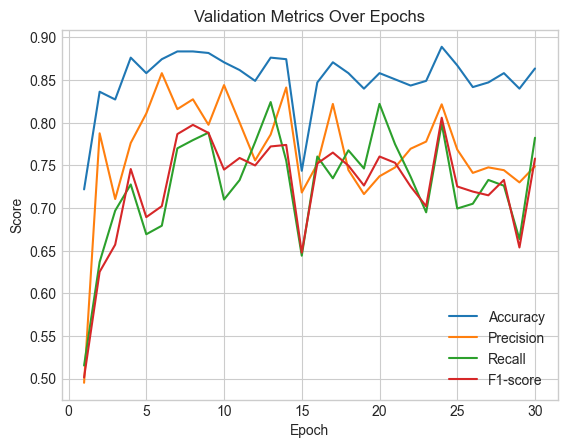

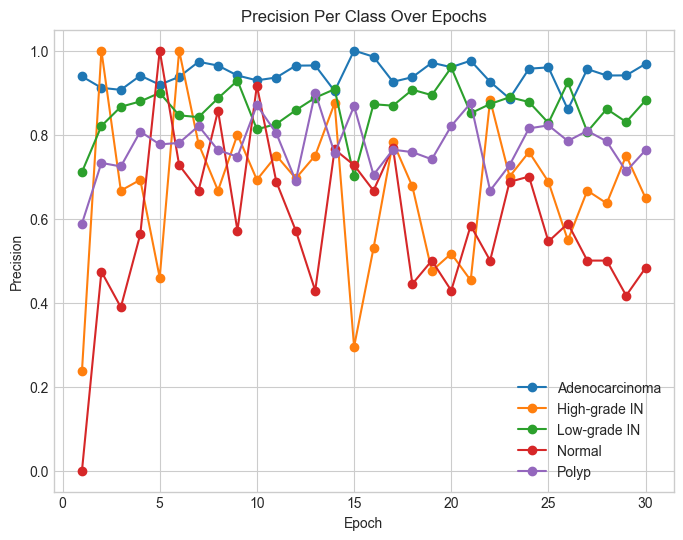

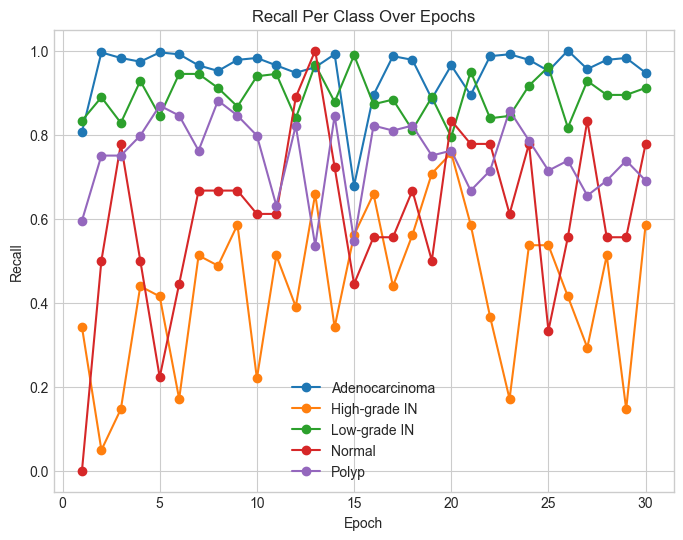

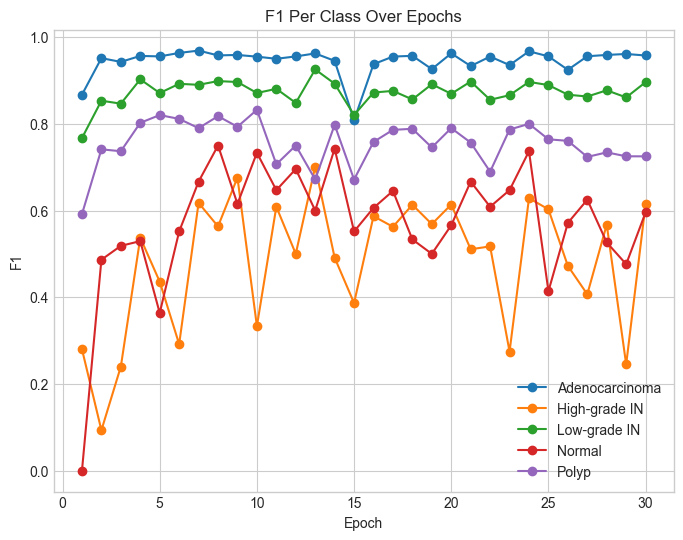

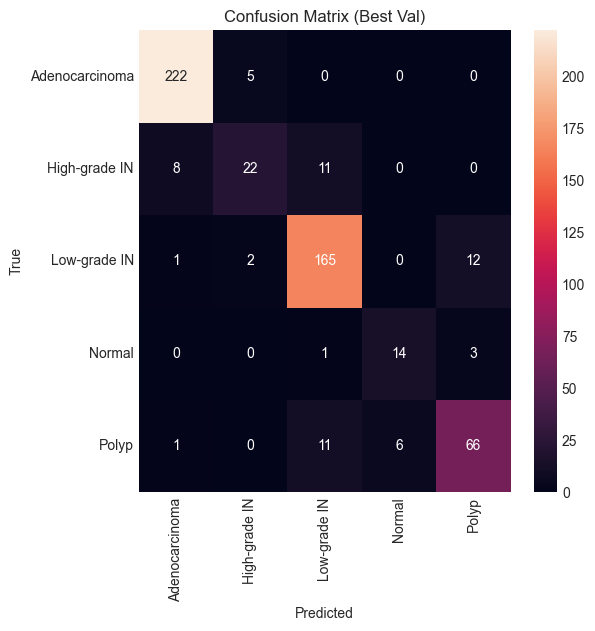

In [74]:
import sys, os

# clear Jupyter's own args
sys.argv = sys.argv[:1]

dataset_path = os.path.abspath(os.path.join(os.getcwd(), "dataset"))
if not os.path.isdir(dataset_path):
    raise RuntimeError(f"❌ Dataset folder not found at {dataset_path}")

sys.argv += [
    "--data_dir", dataset_path,
    "--epochs", "30",
    "--batch_size", "8",
    "--lr", "5e-4",
    "--img_size", "512",
    "--optimizer", "adamw",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal+dice",  # ✅ matches parser
]

print("Launching with:", sys.argv[1:])
main()


Launching with: ['--data_dir', 'C:\\Users\\Georgelele\\PycharmProjects\\Comp9444Proj1\\datasetrebased', '--epochs', '30', '--batch_size', '8', '--lr', '5e-4', '--img_size', '512', '--optimizer', 'adamw', '--num_workers', '4', '--save_dir', 'runs', '--loss', 'focal+dice']
✅ Using dataset: C:\Users\Georgelele\PycharmProjects\Comp9444Proj1\datasetrebased
Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
🧠 Training RESNET | Loss: focal+dice


[Train] Epoch 1: Loss=0.3916, Acc=0.7098


[Val]   Epoch 1: Acc=0.7450, Precision=0.5364, Recall=0.5750, F1=0.5387
✅ Best model updated at epoch 1 with Acc=0.7450


[Train] Epoch 2: Loss=0.2773, Acc=0.7842


[Val]   Epoch 2: Acc=0.8264, Precision=0.6483, Recall=0.5898, F1=0.5772
✅ Best model updated at epoch 2 with Acc=0.8264


[Train] Epoch 3: Loss=0.2385, Acc=0.8108


[Val]   Epoch 3: Acc=0.8354, Precision=0.7173, Recall=0.6467, F1=0.6616
✅ Best model updated at epoch 3 with Acc=0.8354


[Train] Epoch 4: Loss=0.2109, Acc=0.8353


[Val]   Epoch 4: Acc=0.7993, Precision=0.6797, Recall=0.6886, F1=0.6743


[Train] Epoch 5: Loss=0.2121, Acc=0.8418


[Val]   Epoch 5: Acc=0.7848, Precision=0.6810, Recall=0.6512, F1=0.6505


[Train] Epoch 6: Loss=0.1887, Acc=0.8540


[Val]   Epoch 6: Acc=0.8571, Precision=0.8246, Recall=0.7023, F1=0.7399
✅ Best model updated at epoch 6 with Acc=0.8571


[Train] Epoch 7: Loss=0.1974, Acc=0.8463


[Val]   Epoch 7: Acc=0.8047, Precision=0.6995, Recall=0.7336, F1=0.6570


[Train] Epoch 8: Loss=0.1694, Acc=0.8725


[Val]   Epoch 8: Acc=0.8391, Precision=0.7396, Recall=0.7481, F1=0.7353


[Train] Epoch 9: Loss=0.1426, Acc=0.8913


[Val]   Epoch 9: Acc=0.8680, Precision=0.7969, Recall=0.7085, F1=0.7207
✅ Best model updated at epoch 9 with Acc=0.8680


[Train] Epoch 10: Loss=0.1489, Acc=0.8884


[Val]   Epoch 10: Acc=0.8843, Precision=0.8100, Recall=0.7341, F1=0.7577
✅ Best model updated at epoch 10 with Acc=0.8843


[Train] Epoch 11: Loss=0.1189, Acc=0.9112


[Val]   Epoch 11: Acc=0.8626, Precision=0.8679, Recall=0.6888, F1=0.7275


[Train] Epoch 12: Loss=0.1124, Acc=0.9162


[Val]   Epoch 12: Acc=0.8969, Precision=0.8627, Recall=0.7724, F1=0.8008
✅ Best model updated at epoch 12 with Acc=0.8969


[Train] Epoch 13: Loss=0.0905, Acc=0.9327


[Val]   Epoch 13: Acc=0.8662, Precision=0.7666, Recall=0.7509, F1=0.7509


[Train] Epoch 14: Loss=0.1151, Acc=0.9121


[Val]   Epoch 14: Acc=0.8915, Precision=0.8388, Recall=0.7786, F1=0.7956


[Train] Epoch 15: Loss=0.0776, Acc=0.9385


[Val]   Epoch 15: Acc=0.8644, Precision=0.8270, Recall=0.7369, F1=0.7571


[Train] Epoch 16: Loss=0.0675, Acc=0.9523


[Val]   Epoch 16: Acc=0.8861, Precision=0.8139, Recall=0.7805, F1=0.7956


[Train] Epoch 17: Loss=0.0611, Acc=0.9557


[Val]   Epoch 17: Acc=0.8499, Precision=0.7317, Recall=0.7578, F1=0.7401


[Train] Epoch 18: Loss=0.0705, Acc=0.9487


[Val]   Epoch 18: Acc=0.8698, Precision=0.7909, Recall=0.7452, F1=0.7511


[Train] Epoch 19: Loss=0.0415, Acc=0.9677


[Val]   Epoch 19: Acc=0.8535, Precision=0.7421, Recall=0.7901, F1=0.7390


[Train] Epoch 20: Loss=0.0463, Acc=0.9629


[Val]   Epoch 20: Acc=0.8933, Precision=0.8251, Recall=0.7736, F1=0.7903


[Train] Epoch 21: Loss=0.0342, Acc=0.9754


[Val]   Epoch 21: Acc=0.8119, Precision=0.7144, Recall=0.7980, F1=0.7392


[Train] Epoch 22: Loss=0.0462, Acc=0.9656


[Val]   Epoch 22: Acc=0.8734, Precision=0.7820, Recall=0.7887, F1=0.7752


[Train] Epoch 23: Loss=0.0341, Acc=0.9781


[Val]   Epoch 23: Acc=0.8571, Precision=0.8034, Recall=0.6222, F1=0.6349


[Train] Epoch 24: Loss=0.0395, Acc=0.9702


[Val]   Epoch 24: Acc=0.8825, Precision=0.8489, Recall=0.7464, F1=0.7661


[Train] Epoch 25: Loss=0.0214, Acc=0.9869


[Val]   Epoch 25: Acc=0.8915, Precision=0.7995, Recall=0.8173, F1=0.8031


[Train] Epoch 26: Loss=0.0360, Acc=0.9731


[Val]   Epoch 26: Acc=0.8571, Precision=0.7945, Recall=0.7800, F1=0.7820


[Train] Epoch 27: Loss=0.0311, Acc=0.9758


[Val]   Epoch 27: Acc=0.8626, Precision=0.7953, Recall=0.7354, F1=0.7605


[Train] Epoch 28: Loss=0.0251, Acc=0.9833


[Val]   Epoch 28: Acc=0.7993, Precision=0.7068, Recall=0.7680, F1=0.7203


[Train] Epoch 29: Loss=0.0294, Acc=0.9792


[Val]   Epoch 29: Acc=0.8463, Precision=0.7200, Recall=0.7445, F1=0.7233


[Train] Epoch 30: Loss=0.0275, Acc=0.9794


[Val]   Epoch 30: Acc=0.8807, Precision=0.7794, Recall=0.7901, F1=0.7821


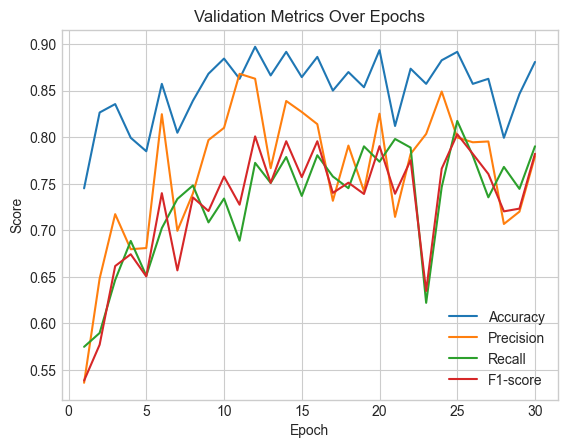

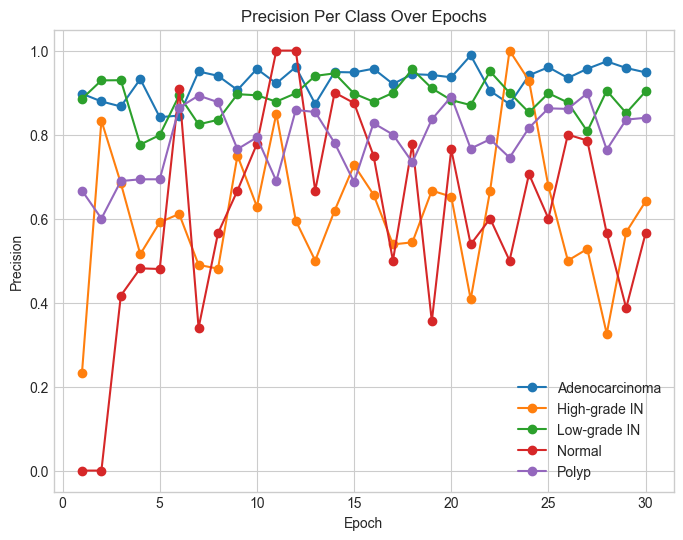

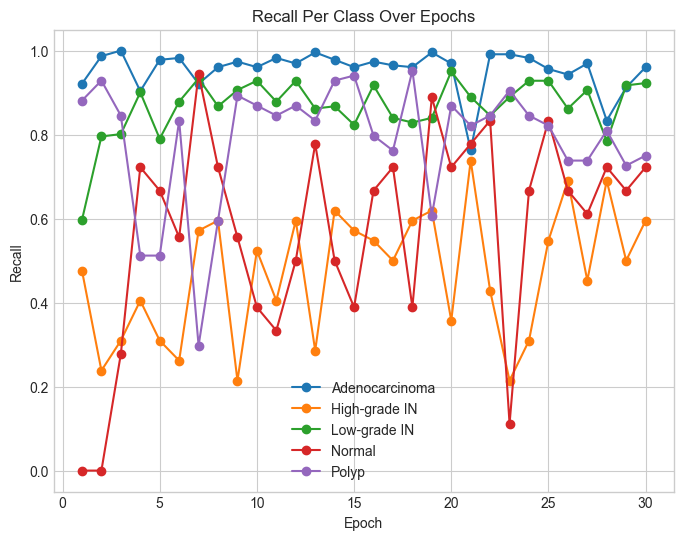

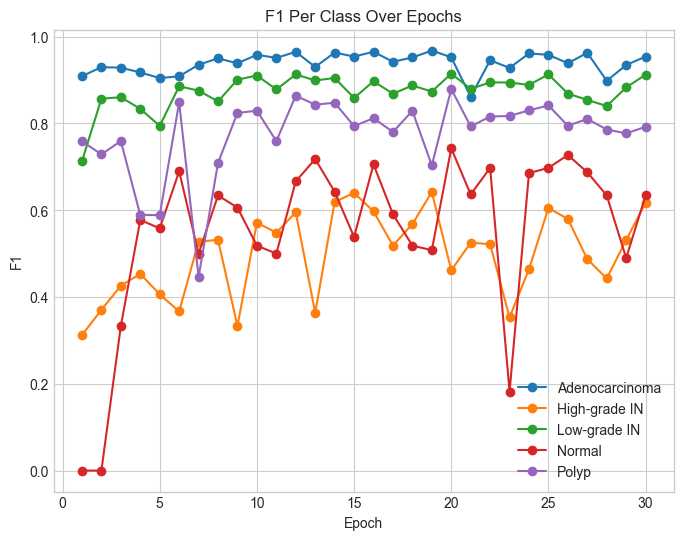

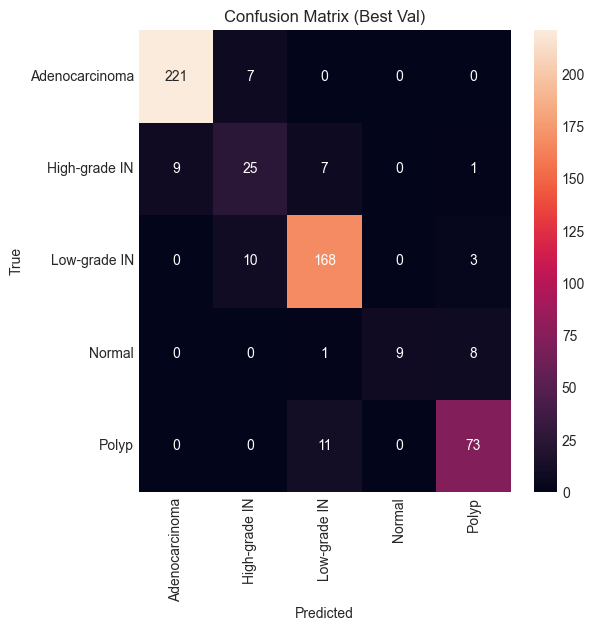

In [75]:
import sys, os

# clear Jupyter's own args
sys.argv = sys.argv[:1]

dataset_path = os.path.abspath(os.path.join(os.getcwd(), "datasetrebased"))
if not os.path.isdir(dataset_path):
    raise RuntimeError(f"❌ Dataset folder not found at {dataset_path}")

sys.argv += [
    "--data_dir", dataset_path,
    "--epochs", "30",
    "--batch_size", "8",
    "--lr", "5e-4",
    "--img_size", "512",
    "--optimizer", "adamw",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal+dice",  # ✅ matches parser
]

print("Launching with:", sys.argv[1:])
main()


Launching with: ['--data_dir', 'C:\\Users\\Georgelele\\PycharmProjects\\Comp9444Proj1\\datasetrebased', '--epochs', '30', '--batch_size', '32', '--lr', '1e-4', '--img_size', '256', '--optimizer', 'adamw', '--num_workers', '4', '--save_dir', 'runs', '--loss', 'focal+tversky']
✅ Using dataset: C:\Users\Georgelele\PycharmProjects\Comp9444Proj1\datasetrebased
Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
🧠 Training RESNET | Loss: focal+tversky


[Train] Epoch 1: Loss=0.2391, Acc=0.8201


[Val]   Epoch 1: Acc=0.8825, Precision=0.8017, Recall=0.7636, F1=0.7700
✅ Best model updated at epoch 1 with Acc=0.8825


[Train] Epoch 2: Loss=0.1154, Acc=0.9144


[Val]   Epoch 2: Acc=0.8825, Precision=0.7800, Recall=0.8139, F1=0.7919


[Train] Epoch 3: Loss=0.0672, Acc=0.9514


[Val]   Epoch 3: Acc=0.8318, Precision=0.7766, Recall=0.7422, F1=0.7458


[Train] Epoch 4: Loss=0.0521, Acc=0.9598


[Val]   Epoch 4: Acc=0.9005, Precision=0.8357, Recall=0.8268, F1=0.8293
✅ Best model updated at epoch 4 with Acc=0.9005


[Train] Epoch 5: Loss=0.0310, Acc=0.9792


[Val]   Epoch 5: Acc=0.8915, Precision=0.8014, Recall=0.8401, F1=0.8151


[Train] Epoch 6: Loss=0.0258, Acc=0.9799


[Val]   Epoch 6: Acc=0.8915, Precision=0.8683, Recall=0.7711, F1=0.8011


[Train] Epoch 7: Loss=0.0313, Acc=0.9779


[Val]   Epoch 7: Acc=0.8969, Precision=0.8450, Recall=0.8204, F1=0.8312


[Train] Epoch 8: Loss=0.0267, Acc=0.9810


[Val]   Epoch 8: Acc=0.8915, Precision=0.8355, Recall=0.7757, F1=0.7974


[Train] Epoch 9: Loss=0.0138, Acc=0.9912


[Val]   Epoch 9: Acc=0.9078, Precision=0.9046, Recall=0.7729, F1=0.8167
✅ Best model updated at epoch 9 with Acc=0.9078


[Train] Epoch 10: Loss=0.0205, Acc=0.9855


[Val]   Epoch 10: Acc=0.9042, Precision=0.8674, Recall=0.8455, F1=0.8550


[Train] Epoch 11: Loss=0.0106, Acc=0.9944


[Val]   Epoch 11: Acc=0.9168, Precision=0.8905, Recall=0.8217, F1=0.8489
✅ Best model updated at epoch 11 with Acc=0.9168


[Train] Epoch 12: Loss=0.0148, Acc=0.9901


[Val]   Epoch 12: Acc=0.9186, Precision=0.8631, Recall=0.8222, F1=0.8405
✅ Best model updated at epoch 12 with Acc=0.9186


[Train] Epoch 13: Loss=0.0156, Acc=0.9887


[Val]   Epoch 13: Acc=0.9277, Precision=0.8722, Recall=0.8798, F1=0.8757
✅ Best model updated at epoch 13 with Acc=0.9277


[Train] Epoch 14: Loss=0.0156, Acc=0.9916


[Val]   Epoch 14: Acc=0.9042, Precision=0.8669, Recall=0.8271, F1=0.8442


[Train] Epoch 15: Loss=0.0112, Acc=0.9930


[Val]   Epoch 15: Acc=0.9042, Precision=0.8544, Recall=0.8399, F1=0.8395


[Train] Epoch 16: Loss=0.0085, Acc=0.9948


[Val]   Epoch 16: Acc=0.8879, Precision=0.8634, Recall=0.7804, F1=0.7916


[Train] Epoch 17: Loss=0.0079, Acc=0.9946


[Val]   Epoch 17: Acc=0.9222, Precision=0.8746, Recall=0.8496, F1=0.8596


[Train] Epoch 18: Loss=0.0063, Acc=0.9966


[Val]   Epoch 18: Acc=0.9132, Precision=0.8626, Recall=0.8040, F1=0.8290


[Train] Epoch 19: Loss=0.0248, Acc=0.9835


[Val]   Epoch 19: Acc=0.8698, Precision=0.7860, Recall=0.8104, F1=0.7923


[Train] Epoch 20: Loss=0.0215, Acc=0.9844


[Val]   Epoch 20: Acc=0.8788, Precision=0.7970, Recall=0.7902, F1=0.7916


[Train] Epoch 21: Loss=0.0107, Acc=0.9925


[Val]   Epoch 21: Acc=0.9241, Precision=0.9031, Recall=0.8366, F1=0.8616


[Train] Epoch 22: Loss=0.0096, Acc=0.9950


[Val]   Epoch 22: Acc=0.8987, Precision=0.8239, Recall=0.8267, F1=0.8247


[Train] Epoch 23: Loss=0.0023, Acc=0.9989


[Val]   Epoch 23: Acc=0.9096, Precision=0.8660, Recall=0.7986, F1=0.8222


[Train] Epoch 24: Loss=0.0012, Acc=0.9991


[Val]   Epoch 24: Acc=0.9005, Precision=0.8551, Recall=0.8116, F1=0.8256


[Train] Epoch 25: Loss=0.0016, Acc=0.9993


[Val]   Epoch 25: Acc=0.9042, Precision=0.8683, Recall=0.8144, F1=0.8308


[Train] Epoch 26: Loss=0.0051, Acc=0.9977


[Val]   Epoch 26: Acc=0.9132, Precision=0.8676, Recall=0.8172, F1=0.8383


[Train] Epoch 27: Loss=0.0069, Acc=0.9950


[Val]   Epoch 27: Acc=0.8933, Precision=0.8434, Recall=0.7821, F1=0.8056


[Train] Epoch 28: Loss=0.0222, Acc=0.9849


[Val]   Epoch 28: Acc=0.8915, Precision=0.8282, Recall=0.7927, F1=0.8036


[Train] Epoch 29: Loss=0.0427, Acc=0.9722


[Val]   Epoch 29: Acc=0.8861, Precision=0.8478, Recall=0.7803, F1=0.7921


[Train] Epoch 30: Loss=0.0183, Acc=0.9878


[Val]   Epoch 30: Acc=0.8951, Precision=0.8349, Recall=0.8030, F1=0.8139


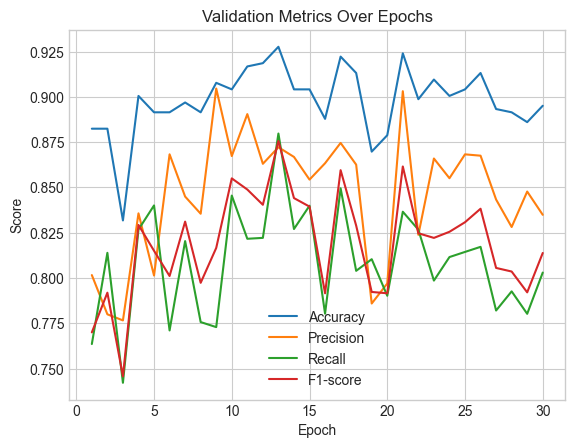

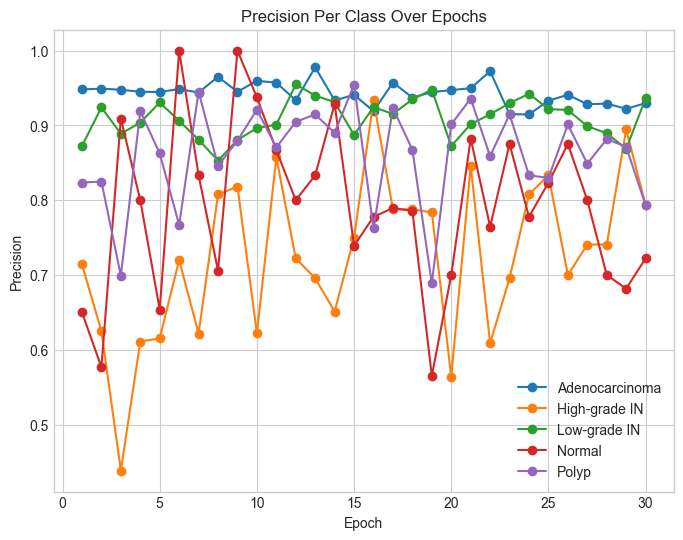

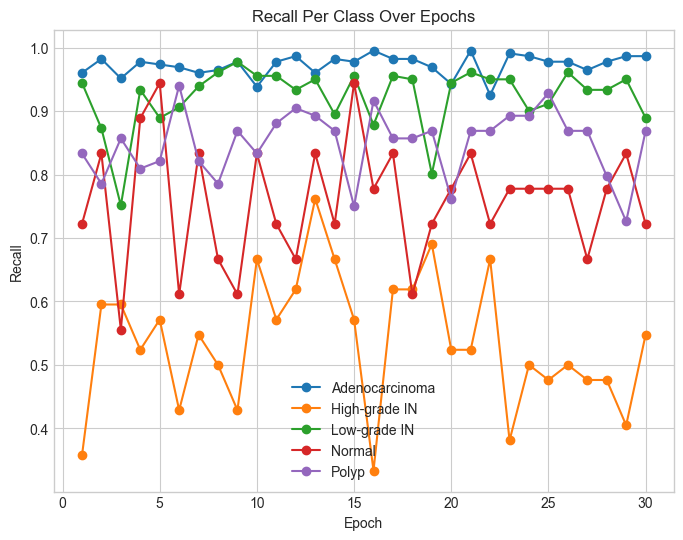

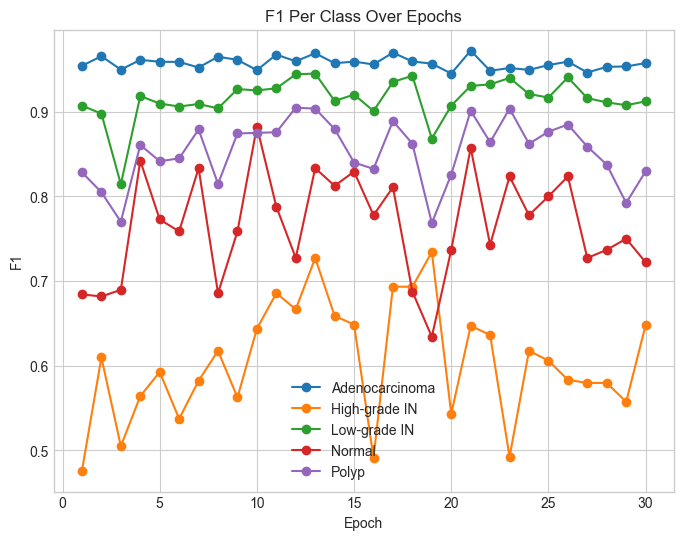

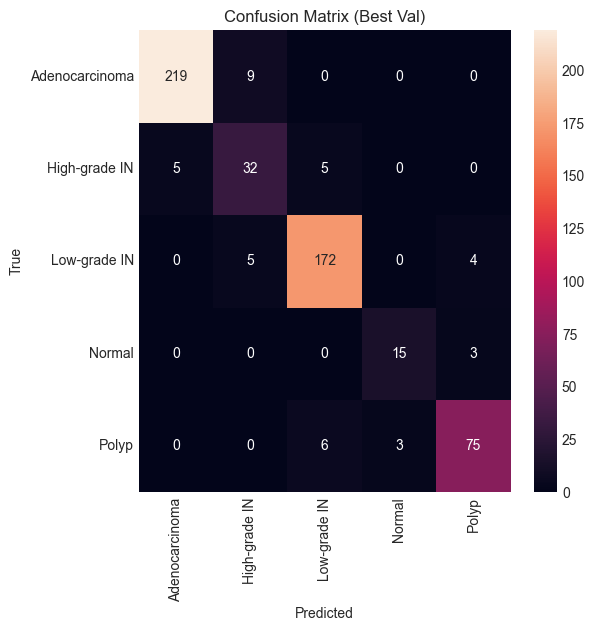

In [77]:
import sys, os

# clear Jupyter's own args
sys.argv = sys.argv[:1]

dataset_path = os.path.abspath(os.path.join(os.getcwd(), "datasetrebased"))
if not os.path.isdir(dataset_path):
    raise RuntimeError(f"❌ Dataset folder not found at {dataset_path}")

sys.argv += [
    "--data_dir", dataset_path,
    "--epochs", "30",
    "--batch_size", "32",
    "--lr", "1e-4",
    "--img_size", "256",
    "--optimizer", "adamw",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal+tversky",  # ✅ matches parser
]

print("Launching with:", sys.argv[1:])
main()


✅ Using dataset: datasetrebased
Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
🧠 Training DENSENET | Loss: focal+tversky


[Train] Epoch 1: Loss=0.2515, Acc=0.8199


[Val]   Epoch 1: Acc=0.8843, Precision=0.8015, Recall=0.7065, F1=0.7319
✅ Best model updated at epoch 1 with Acc=0.8843


Epoch 2/30 [Train]:  19%|█▊        | 26/139 [00:22<00:42,  2.65batch/s, loss=0.1643, acc=0.9243]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000282DE21A950>
Traceback (most recent call last):
  File "D:\Anaconda\envs\yolo5\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "D:\Anaconda\envs\yolo5\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


[Train] Epoch 2: Loss=0.1106, Acc=0.9254


[Val]   Epoch 2: Acc=0.9005, Precision=0.8401, Recall=0.8009, F1=0.8163
✅ Best model updated at epoch 2 with Acc=0.9005


[Train] Epoch 3: Loss=0.0539, Acc=0.9681


[Val]   Epoch 3: Acc=0.8933, Precision=0.8201, Recall=0.7782, F1=0.7939


[Train] Epoch 4: Loss=0.0340, Acc=0.9817


[Val]   Epoch 4: Acc=0.8915, Precision=0.8298, Recall=0.7771, F1=0.7960


[Train] Epoch 5: Loss=0.0317, Acc=0.9812


[Val]   Epoch 5: Acc=0.9042, Precision=0.8324, Recall=0.8089, F1=0.8174
✅ Best model updated at epoch 5 with Acc=0.9042


[Train] Epoch 6: Loss=0.0186, Acc=0.9905


[Val]   Epoch 6: Acc=0.8987, Precision=0.8346, Recall=0.8060, F1=0.8189


[Train] Epoch 7: Loss=0.0235, Acc=0.9844


[Val]   Epoch 7: Acc=0.9150, Precision=0.8686, Recall=0.8287, F1=0.8456
✅ Best model updated at epoch 7 with Acc=0.9150


[Train] Epoch 8: Loss=0.0155, Acc=0.9910


[Val]   Epoch 8: Acc=0.9186, Precision=0.9082, Recall=0.8101, F1=0.8460
✅ Best model updated at epoch 8 with Acc=0.9186


[Train] Epoch 9: Loss=0.0083, Acc=0.9959


[Val]   Epoch 9: Acc=0.9060, Precision=0.8949, Recall=0.7693, F1=0.8058


[Train] Epoch 10: Loss=0.0118, Acc=0.9923


[Val]   Epoch 10: Acc=0.9132, Precision=0.9012, Recall=0.7900, F1=0.8265


[Train] Epoch 11: Loss=0.0168, Acc=0.9914


[Val]   Epoch 11: Acc=0.9042, Precision=0.8461, Recall=0.7989, F1=0.8191


[Train] Epoch 12: Loss=0.0137, Acc=0.9923


[Val]   Epoch 12: Acc=0.9096, Precision=0.8847, Recall=0.7932, F1=0.8270


[Train] Epoch 13: Loss=0.0058, Acc=0.9977


[Val]   Epoch 13: Acc=0.9042, Precision=0.8459, Recall=0.7882, F1=0.8098


[Train] Epoch 14: Loss=0.0082, Acc=0.9959


[Val]   Epoch 14: Acc=0.9078, Precision=0.8609, Recall=0.7998, F1=0.8135


[Train] Epoch 15: Loss=0.0171, Acc=0.9898


[Val]   Epoch 15: Acc=0.8897, Precision=0.8650, Recall=0.7735, F1=0.8069


[Train] Epoch 16: Loss=0.0097, Acc=0.9941


[Val]   Epoch 16: Acc=0.9024, Precision=0.8315, Recall=0.8123, F1=0.8091


[Train] Epoch 17: Loss=0.0108, Acc=0.9932


[Val]   Epoch 17: Acc=0.9060, Precision=0.8520, Recall=0.8047, F1=0.8237


[Train] Epoch 18: Loss=0.0068, Acc=0.9959


[Val]   Epoch 18: Acc=0.9042, Precision=0.8663, Recall=0.7953, F1=0.8236


[Train] Epoch 19: Loss=0.0061, Acc=0.9971


[Val]   Epoch 19: Acc=0.9114, Precision=0.8790, Recall=0.8021, F1=0.8271


[Train] Epoch 20: Loss=0.0053, Acc=0.9973


[Val]   Epoch 20: Acc=0.8915, Precision=0.8345, Recall=0.7492, F1=0.7721


[Train] Epoch 21: Loss=0.0064, Acc=0.9973


[Val]   Epoch 21: Acc=0.8987, Precision=0.8369, Recall=0.7709, F1=0.7862


[Train] Epoch 22: Loss=0.0148, Acc=0.9910


[Val]   Epoch 22: Acc=0.9060, Precision=0.8743, Recall=0.7824, F1=0.8157


[Train] Epoch 23: Loss=0.0100, Acc=0.9955


[Val]   Epoch 23: Acc=0.9024, Precision=0.8801, Recall=0.8089, F1=0.8365


[Train] Epoch 24: Loss=0.0025, Acc=0.9984


[Val]   Epoch 24: Acc=0.9150, Precision=0.8984, Recall=0.7967, F1=0.8343


[Train] Epoch 25: Loss=0.0028, Acc=0.9986


[Val]   Epoch 25: Acc=0.9186, Precision=0.9202, Recall=0.8041, F1=0.8455


[Train] Epoch 26: Loss=0.0074, Acc=0.9957


[Val]   Epoch 26: Acc=0.9078, Precision=0.8700, Recall=0.8025, F1=0.8250


[Train] Epoch 27: Loss=0.0157, Acc=0.9892


[Val]   Epoch 27: Acc=0.9060, Precision=0.8435, Recall=0.7967, F1=0.8160


[Train] Epoch 28: Loss=0.0053, Acc=0.9966


[Val]   Epoch 28: Acc=0.9078, Precision=0.9056, Recall=0.7731, F1=0.8187


[Train] Epoch 29: Loss=0.0043, Acc=0.9971


[Val]   Epoch 29: Acc=0.9114, Precision=0.8788, Recall=0.8057, F1=0.8323


[Train] Epoch 30: Loss=0.0122, Acc=0.9932


[Val]   Epoch 30: Acc=0.9042, Precision=0.9064, Recall=0.7817, F1=0.8216


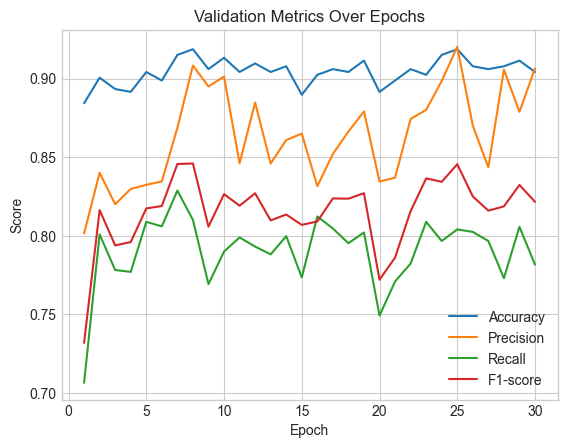

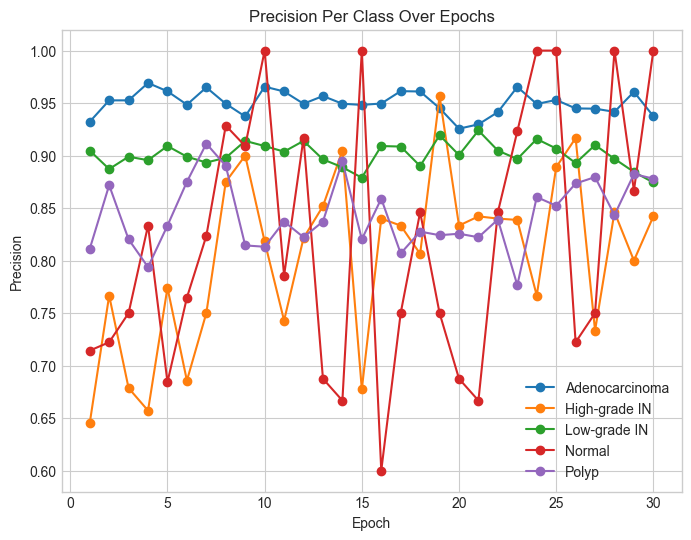

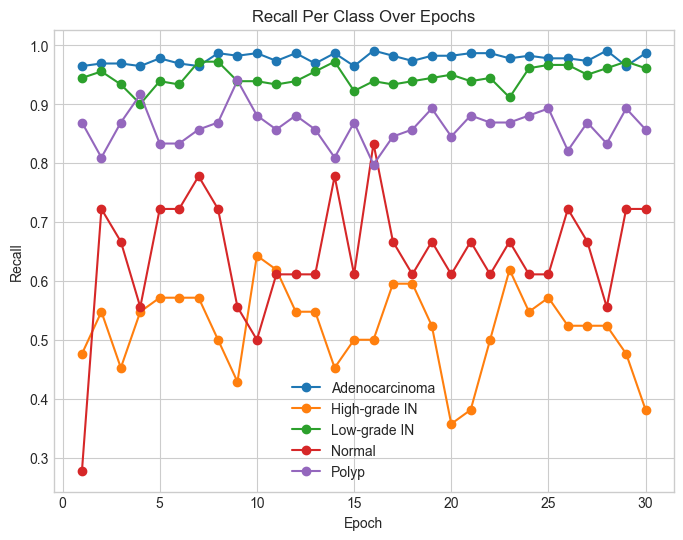

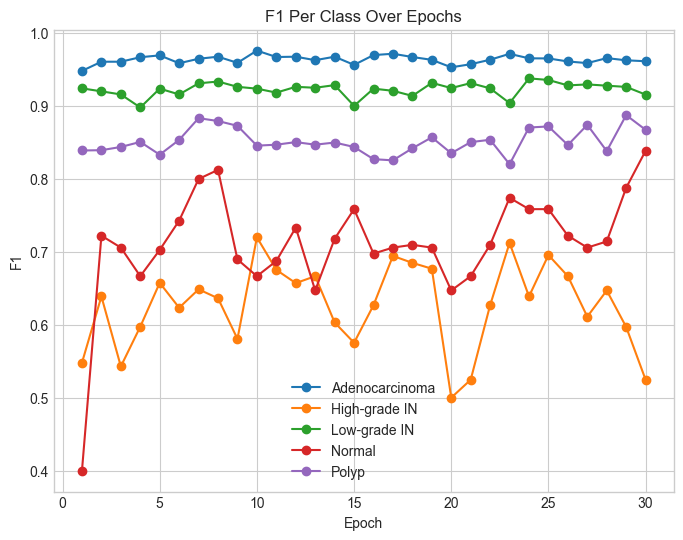

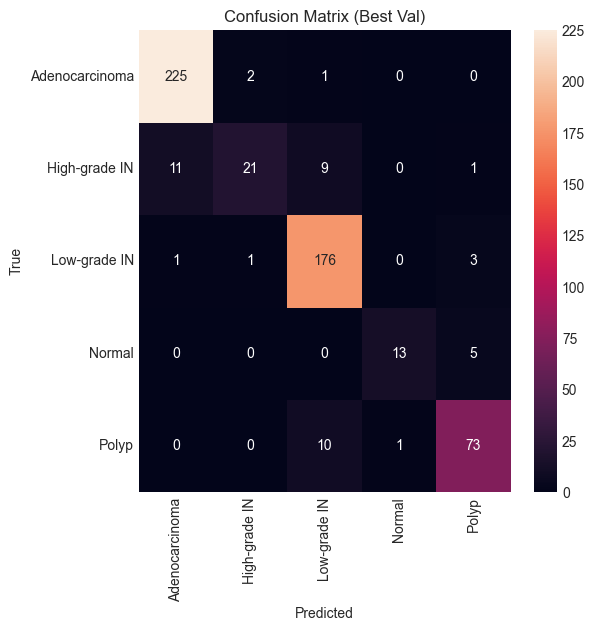

In [78]:
sys.argv = sys.argv[:1]
sys.argv += [
    "--data_dir", "datasetrebased",
    "--epochs", "30",
    "--batch_size", "32",
    "--lr", "1e-4",
    "--img_size", "256",
    "--optimizer", "adamw",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal+tversky",
    "--model", "densenet"  # ✅ Choose model dynamically
]
main()

✅ Using dataset: dataset
Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
🧠 Training DENSENET | Loss: focal


[Train] Epoch 1: Loss=0.2077, Acc=0.7854


[Val]   Epoch 1: Acc=0.8436, Precision=0.7709, Recall=0.6836, F1=0.7015
✅ Best model updated at epoch 1 with Acc=0.8436


[Train] Epoch 2: Loss=0.1236, Acc=0.8499


[Val]   Epoch 2: Acc=0.8073, Precision=0.7491, Recall=0.7781, F1=0.7505


[Train] Epoch 3: Loss=0.0833, Acc=0.8946


[Val]   Epoch 3: Acc=0.7000, Precision=0.6256, Recall=0.6476, F1=0.6061


[Train] Epoch 4: Loss=0.0707, Acc=0.9091


[Val]   Epoch 4: Acc=0.8309, Precision=0.7428, Recall=0.7784, F1=0.7059


[Train] Epoch 5: Loss=0.0561, Acc=0.9225


[Val]   Epoch 5: Acc=0.8455, Precision=0.7826, Recall=0.8033, F1=0.7770
✅ Best model updated at epoch 5 with Acc=0.8455


[Train] Epoch 6: Loss=0.0635, Acc=0.9195


[Val]   Epoch 6: Acc=0.8764, Precision=0.8402, Recall=0.7482, F1=0.7654
✅ Best model updated at epoch 6 with Acc=0.8764


[Train] Epoch 7: Loss=0.0386, Acc=0.9421


[Val]   Epoch 7: Acc=0.8927, Precision=0.8004, Recall=0.8170, F1=0.8045
✅ Best model updated at epoch 7 with Acc=0.8927


[Train] Epoch 8: Loss=0.0308, Acc=0.9573


[Val]   Epoch 8: Acc=0.9127, Precision=0.8935, Recall=0.8314, F1=0.8563
✅ Best model updated at epoch 8 with Acc=0.9127


[Train] Epoch 9: Loss=0.0197, Acc=0.9699


[Val]   Epoch 9: Acc=0.9182, Precision=0.8429, Recall=0.8838, F1=0.8580
✅ Best model updated at epoch 9 with Acc=0.9182


[Train] Epoch 10: Loss=0.0460, Acc=0.9362


[Val]   Epoch 10: Acc=0.8709, Precision=0.7589, Recall=0.7651, F1=0.7598


[Train] Epoch 11: Loss=0.0458, Acc=0.9385


[Val]   Epoch 11: Acc=0.8964, Precision=0.8433, Recall=0.8386, F1=0.8401


[Train] Epoch 12: Loss=0.0288, Acc=0.9566


[Val]   Epoch 12: Acc=0.9327, Precision=0.9243, Recall=0.8561, F1=0.8859
✅ Best model updated at epoch 12 with Acc=0.9327


[Train] Epoch 13: Loss=0.0081, Acc=0.9878


[Val]   Epoch 13: Acc=0.8927, Precision=0.8049, Recall=0.8244, F1=0.8071


[Train] Epoch 14: Loss=0.0946, Acc=0.8978


[Val]   Epoch 14: Acc=0.8745, Precision=0.8032, Recall=0.7688, F1=0.7715


[Train] Epoch 15: Loss=0.0222, Acc=0.9679


[Val]   Epoch 15: Acc=0.9055, Precision=0.8519, Recall=0.8514, F1=0.8468


[Train] Epoch 16: Loss=0.0068, Acc=0.9894


[Val]   Epoch 16: Acc=0.9200, Precision=0.8674, Recall=0.8641, F1=0.8630


[Train] Epoch 17: Loss=0.0208, Acc=0.9677


[Val]   Epoch 17: Acc=0.8945, Precision=0.8584, Recall=0.7937, F1=0.8177


[Train] Epoch 18: Loss=0.0105, Acc=0.9835


[Val]   Epoch 18: Acc=0.9145, Precision=0.8332, Recall=0.8363, F1=0.8337


[Train] Epoch 19: Loss=0.0129, Acc=0.9824


[Val]   Epoch 19: Acc=0.8982, Precision=0.8105, Recall=0.8423, F1=0.8239


[Train] Epoch 20: Loss=0.0206, Acc=0.9670


[Val]   Epoch 20: Acc=0.8927, Precision=0.7981, Recall=0.8243, F1=0.8093


[Train] Epoch 21: Loss=0.0144, Acc=0.9774


[Val]   Epoch 21: Acc=0.9255, Precision=0.8680, Recall=0.8626, F1=0.8638


[Train] Epoch 22: Loss=0.0249, Acc=0.9695


[Val]   Epoch 22: Acc=0.8927, Precision=0.8409, Recall=0.8336, F1=0.8329


[Train] Epoch 23: Loss=0.0117, Acc=0.9846


[Val]   Epoch 23: Acc=0.8873, Precision=0.7891, Recall=0.8596, F1=0.8152


[Train] Epoch 24: Loss=0.0302, Acc=0.9570


[Val]   Epoch 24: Acc=0.8818, Precision=0.7891, Recall=0.8335, F1=0.7917


[Train] Epoch 25: Loss=0.0049, Acc=0.9932


[Val]   Epoch 25: Acc=0.8764, Precision=0.7954, Recall=0.8387, F1=0.8115


[Train] Epoch 26: Loss=0.0092, Acc=0.9867


[Val]   Epoch 26: Acc=0.9182, Precision=0.8967, Recall=0.8337, F1=0.8578


[Train] Epoch 27: Loss=0.0034, Acc=0.9946


[Val]   Epoch 27: Acc=0.9164, Precision=0.8440, Recall=0.8750, F1=0.8557


[Train] Epoch 28: Loss=0.0570, Acc=0.9306


[Val]   Epoch 28: Acc=0.8636, Precision=0.7642, Recall=0.7844, F1=0.7542


[Train] Epoch 29: Loss=0.0115, Acc=0.9833


[Val]   Epoch 29: Acc=0.9018, Precision=0.8112, Recall=0.8288, F1=0.8153


[Train] Epoch 30: Loss=0.0050, Acc=0.9925


[Val]   Epoch 30: Acc=0.9127, Precision=0.8719, Recall=0.7683, F1=0.8029


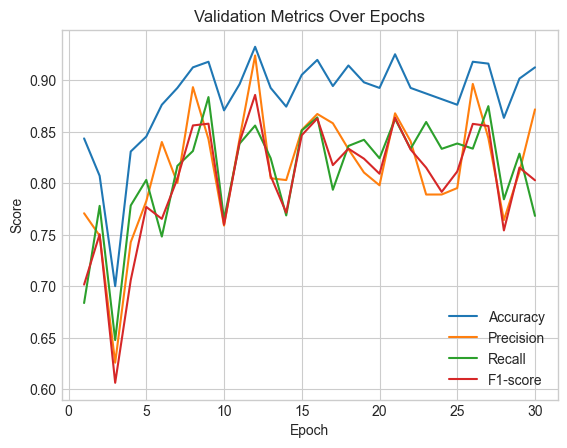

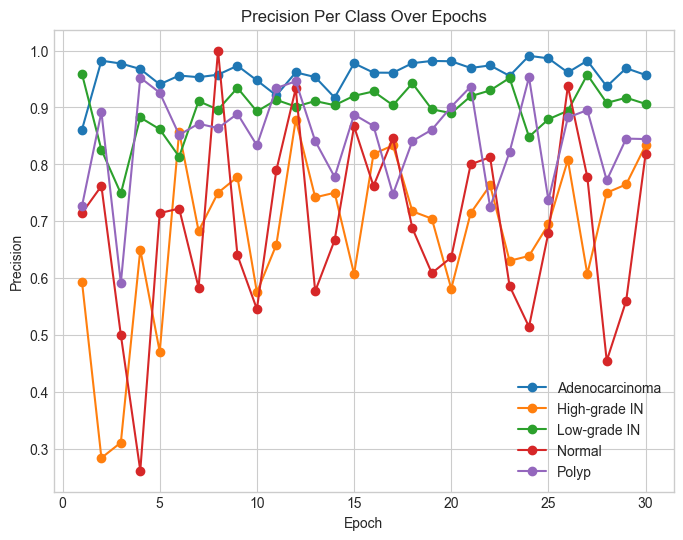

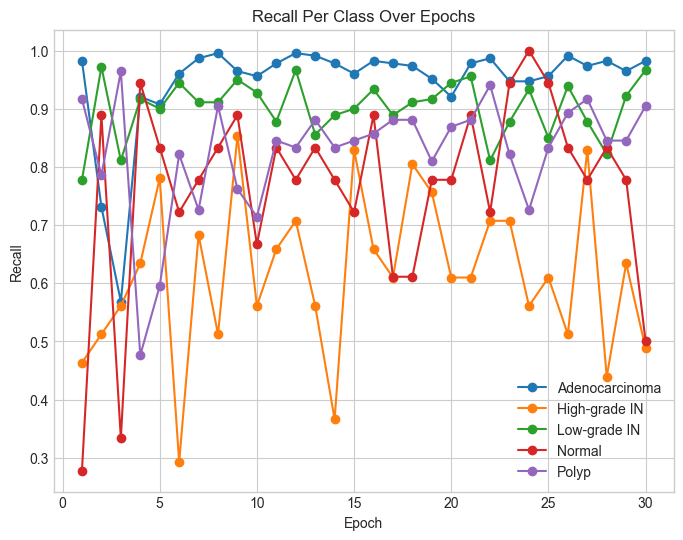

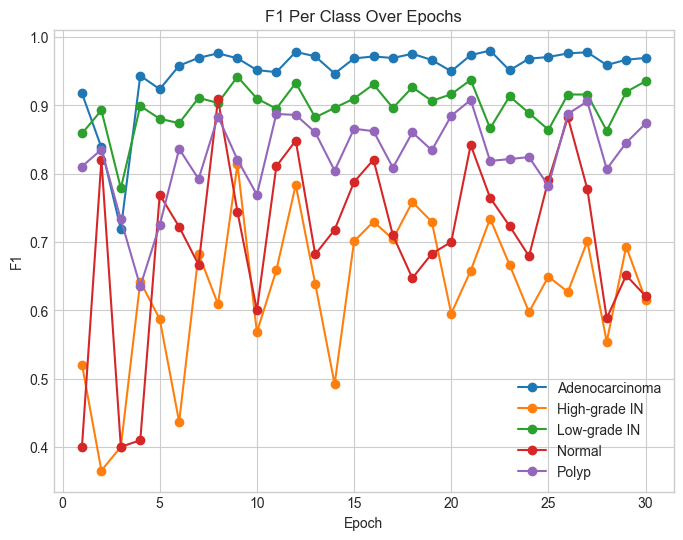

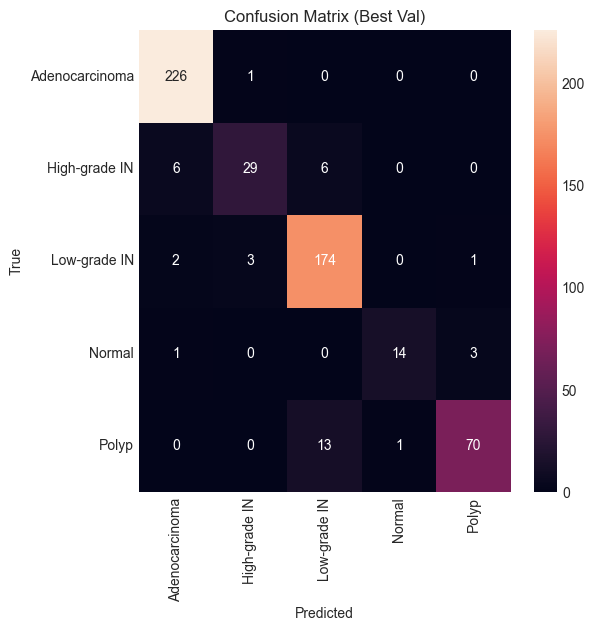

In [79]:
sys.argv = sys.argv[:1]
sys.argv += [
    "--data_dir", "dataset",
    "--epochs", "30",
    "--batch_size", "32",
    "--lr", "5e-4",
    "--img_size", "256",
    "--optimizer", "adam",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal",
    "--model", "densenet"  # ✅ Choose model dynamically
]
main()

✅ Using dataset: datasetrebased
Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
🧠 Training EFFICIENTNET | Loss: tversky


[Train] Epoch 1: Loss=0.3163, Acc=0.7632


[Val]   Epoch 1: Acc=0.8445, Precision=0.6930, Recall=0.5664, F1=0.5433
✅ Best model updated at epoch 1 with Acc=0.8445


[Train] Epoch 2: Loss=0.1830, Acc=0.8264


[Val]   Epoch 2: Acc=0.8481, Precision=0.6960, Recall=0.5627, F1=0.5344
✅ Best model updated at epoch 2 with Acc=0.8481


[Train] Epoch 3: Loss=0.1556, Acc=0.8558


[Val]   Epoch 3: Acc=0.8716, Precision=0.8473, Recall=0.6829, F1=0.7064
✅ Best model updated at epoch 3 with Acc=0.8716


[Train] Epoch 4: Loss=0.1285, Acc=0.8829


[Val]   Epoch 4: Acc=0.8734, Precision=0.8451, Recall=0.7531, F1=0.7846
✅ Best model updated at epoch 4 with Acc=0.8734


[Train] Epoch 5: Loss=0.1046, Acc=0.9049


[Val]   Epoch 5: Acc=0.8843, Precision=0.8265, Recall=0.7727, F1=0.7905
✅ Best model updated at epoch 5 with Acc=0.8843


[Train] Epoch 6: Loss=0.0948, Acc=0.9105


[Val]   Epoch 6: Acc=0.8861, Precision=0.8079, Recall=0.7632, F1=0.7821
✅ Best model updated at epoch 6 with Acc=0.8861


[Train] Epoch 7: Loss=0.0811, Acc=0.9247


[Val]   Epoch 7: Acc=0.8933, Precision=0.8154, Recall=0.7573, F1=0.7756
✅ Best model updated at epoch 7 with Acc=0.8933


[Train] Epoch 8: Loss=0.0728, Acc=0.9331


[Val]   Epoch 8: Acc=0.8933, Precision=0.8398, Recall=0.7899, F1=0.8116


[Train] Epoch 9: Loss=0.0720, Acc=0.9329


[Val]   Epoch 9: Acc=0.9024, Precision=0.8584, Recall=0.7830, F1=0.8091
✅ Best model updated at epoch 9 with Acc=0.9024


[Train] Epoch 10: Loss=0.0571, Acc=0.9476


[Val]   Epoch 10: Acc=0.9005, Precision=0.8580, Recall=0.7859, F1=0.8133


[Train] Epoch 11: Loss=0.0526, Acc=0.9505


[Val]   Epoch 11: Acc=0.9005, Precision=0.8645, Recall=0.7782, F1=0.8073


[Train] Epoch 12: Loss=0.0497, Acc=0.9546


[Val]   Epoch 12: Acc=0.9060, Precision=0.8656, Recall=0.7997, F1=0.8258
✅ Best model updated at epoch 12 with Acc=0.9060


[Train] Epoch 13: Loss=0.0491, Acc=0.9555


[Val]   Epoch 13: Acc=0.9078, Precision=0.8566, Recall=0.8109, F1=0.8297
✅ Best model updated at epoch 13 with Acc=0.9078


[Train] Epoch 14: Loss=0.0474, Acc=0.9571


[Val]   Epoch 14: Acc=0.8987, Precision=0.8842, Recall=0.7854, F1=0.8162


[Train] Epoch 15: Loss=0.0393, Acc=0.9652


[Val]   Epoch 15: Acc=0.9042, Precision=0.8751, Recall=0.8063, F1=0.8324


[Train] Epoch 16: Loss=0.0399, Acc=0.9625


[Val]   Epoch 16: Acc=0.9114, Precision=0.8839, Recall=0.8095, F1=0.8347
✅ Best model updated at epoch 16 with Acc=0.9114


[Train] Epoch 17: Loss=0.0373, Acc=0.9650


[Val]   Epoch 17: Acc=0.8951, Precision=0.8382, Recall=0.8010, F1=0.8171


[Train] Epoch 18: Loss=0.0381, Acc=0.9645


[Val]   Epoch 18: Acc=0.9096, Precision=0.8714, Recall=0.8223, F1=0.8432


[Train] Epoch 19: Loss=0.0332, Acc=0.9697


[Val]   Epoch 19: Acc=0.9042, Precision=0.8336, Recall=0.8137, F1=0.8216


[Train] Epoch 20: Loss=0.0291, Acc=0.9727


[Val]   Epoch 20: Acc=0.9024, Precision=0.8447, Recall=0.8230, F1=0.8312


[Train] Epoch 21: Loss=0.0264, Acc=0.9756


[Val]   Epoch 21: Acc=0.9096, Precision=0.8711, Recall=0.8357, F1=0.8504


[Train] Epoch 22: Loss=0.0249, Acc=0.9767


[Val]   Epoch 22: Acc=0.9114, Precision=0.8566, Recall=0.8040, F1=0.8259


[Train] Epoch 23: Loss=0.0269, Acc=0.9749


[Val]   Epoch 23: Acc=0.9060, Precision=0.8157, Recall=0.8436, F1=0.8255


[Train] Epoch 24: Loss=0.0273, Acc=0.9738


[Val]   Epoch 24: Acc=0.9060, Precision=0.8611, Recall=0.7848, F1=0.8141


[Train] Epoch 25: Loss=0.0276, Acc=0.9742


[Val]   Epoch 25: Acc=0.9096, Precision=0.8881, Recall=0.7946, F1=0.8277


[Train] Epoch 26: Loss=0.0232, Acc=0.9785


[Val]   Epoch 26: Acc=0.9042, Precision=0.8586, Recall=0.8057, F1=0.8281


[Train] Epoch 27: Loss=0.0222, Acc=0.9797


[Val]   Epoch 27: Acc=0.8969, Precision=0.8030, Recall=0.8106, F1=0.8066


[Train] Epoch 28: Loss=0.0209, Acc=0.9806


[Val]   Epoch 28: Acc=0.9132, Precision=0.8952, Recall=0.7973, F1=0.8352
✅ Best model updated at epoch 28 with Acc=0.9132


[Train] Epoch 29: Loss=0.0277, Acc=0.9736


[Val]   Epoch 29: Acc=0.8969, Precision=0.8359, Recall=0.8127, F1=0.8218


[Train] Epoch 30: Loss=0.0217, Acc=0.9799


[Val]   Epoch 30: Acc=0.9241, Precision=0.9088, Recall=0.8377, F1=0.8671
✅ Best model updated at epoch 30 with Acc=0.9241


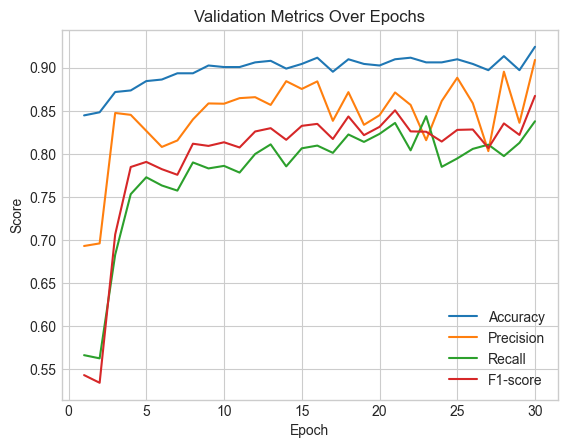

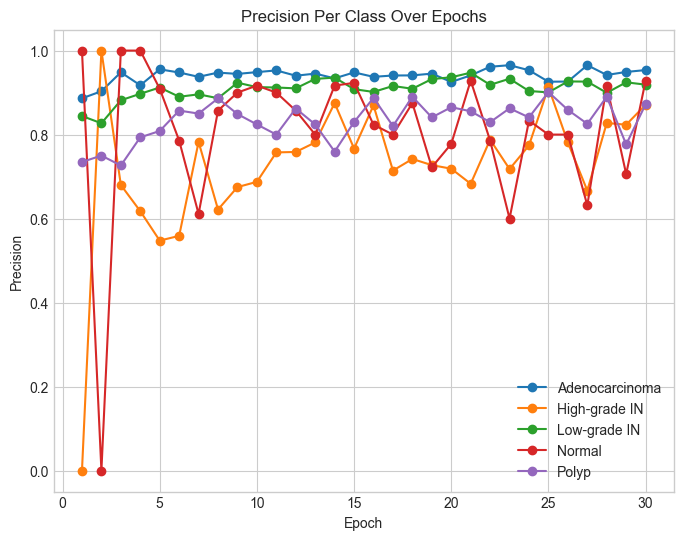

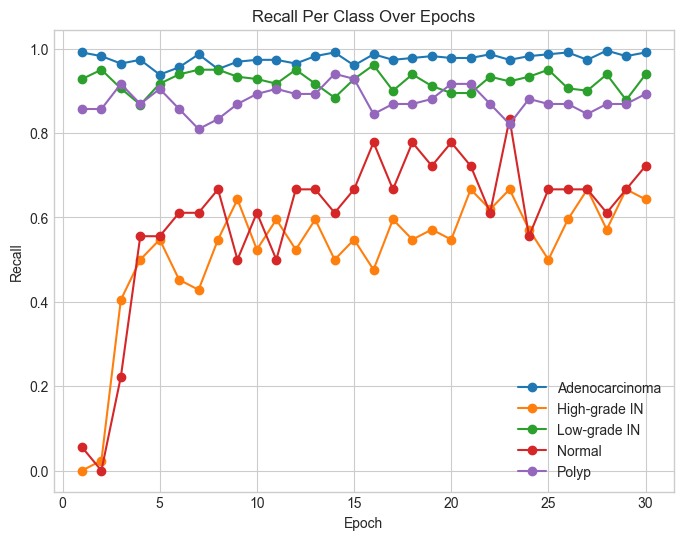

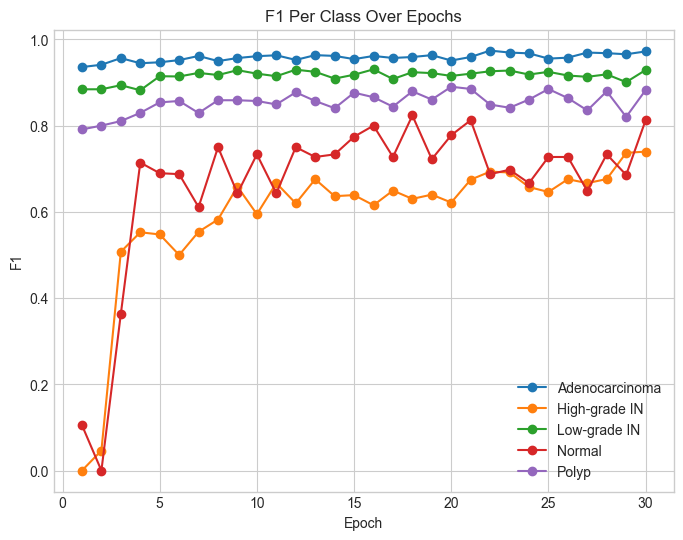

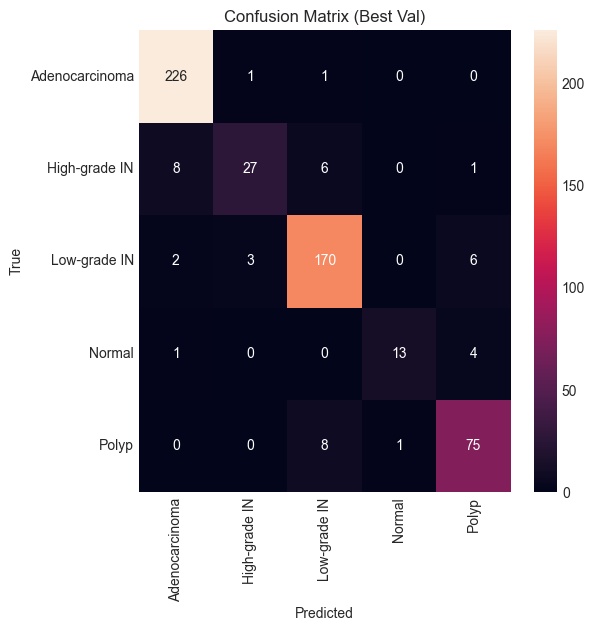

In [82]:

sys.argv = sys.argv[:1]
sys.argv += [
    "--data_dir", "datasetrebased",
    "--epochs", "30",
    "--batch_size", "16",
    "--lr", "1e-4",
    "--img_size", "256",
    "--optimizer", "adam",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "tversky",
    "--model", "efficientnet"  # ✅ Choose model dynamically
]
main()

✅ Using dataset: datasetrebased
Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
🧠 Training EFFICIENTNET | Loss: focal+tversky


[Train] Epoch 1: Loss=0.3576, Acc=0.7636


[Val]   Epoch 1: Acc=0.8445, Precision=0.7485, Recall=0.6336, F1=0.6469
✅ Best model updated at epoch 1 with Acc=0.8445


[Train] Epoch 2: Loss=0.1672, Acc=0.8782


[Val]   Epoch 2: Acc=0.8861, Precision=0.8302, Recall=0.7483, F1=0.7788
✅ Best model updated at epoch 2 with Acc=0.8861


[Train] Epoch 3: Loss=0.1149, Acc=0.9218


[Val]   Epoch 3: Acc=0.8915, Precision=0.8192, Recall=0.7838, F1=0.7990
✅ Best model updated at epoch 3 with Acc=0.8915


[Train] Epoch 4: Loss=0.0812, Acc=0.9460


[Val]   Epoch 4: Acc=0.8843, Precision=0.8048, Recall=0.7858, F1=0.7943


[Train] Epoch 5: Loss=0.0564, Acc=0.9632


[Val]   Epoch 5: Acc=0.9024, Precision=0.8418, Recall=0.7835, F1=0.8071
✅ Best model updated at epoch 5 with Acc=0.9024


[Train] Epoch 6: Loss=0.0443, Acc=0.9713


[Val]   Epoch 6: Acc=0.9096, Precision=0.8643, Recall=0.8208, F1=0.8404
✅ Best model updated at epoch 6 with Acc=0.9096


[Train] Epoch 7: Loss=0.0335, Acc=0.9790


[Val]   Epoch 7: Acc=0.9096, Precision=0.8673, Recall=0.8190, F1=0.8406


[Train] Epoch 8: Loss=0.0344, Acc=0.9792


[Val]   Epoch 8: Acc=0.9096, Precision=0.8556, Recall=0.8043, F1=0.8262


[Train] Epoch 9: Loss=0.0214, Acc=0.9873


[Val]   Epoch 9: Acc=0.9042, Precision=0.8371, Recall=0.8394, F1=0.8363


[Train] Epoch 10: Loss=0.0179, Acc=0.9887


[Val]   Epoch 10: Acc=0.9078, Precision=0.8532, Recall=0.8378, F1=0.8447


[Train] Epoch 11: Loss=0.0168, Acc=0.9889


[Val]   Epoch 11: Acc=0.9150, Precision=0.8649, Recall=0.8504, F1=0.8550
✅ Best model updated at epoch 11 with Acc=0.9150


[Train] Epoch 12: Loss=0.0174, Acc=0.9892


[Val]   Epoch 12: Acc=0.9168, Precision=0.8754, Recall=0.8440, F1=0.8587
✅ Best model updated at epoch 12 with Acc=0.9168


[Train] Epoch 13: Loss=0.0142, Acc=0.9916


[Val]   Epoch 13: Acc=0.9186, Precision=0.8892, Recall=0.8396, F1=0.8612
✅ Best model updated at epoch 13 with Acc=0.9186


[Train] Epoch 14: Loss=0.0128, Acc=0.9921


[Val]   Epoch 14: Acc=0.9168, Precision=0.8775, Recall=0.8454, F1=0.8582


[Train] Epoch 15: Loss=0.0131, Acc=0.9925


[Val]   Epoch 15: Acc=0.8951, Precision=0.8338, Recall=0.8178, F1=0.8234


[Train] Epoch 16: Loss=0.0097, Acc=0.9948


[Val]   Epoch 16: Acc=0.9114, Precision=0.8857, Recall=0.8319, F1=0.8557


[Train] Epoch 17: Loss=0.0097, Acc=0.9948


[Val]   Epoch 17: Acc=0.9078, Precision=0.8676, Recall=0.8432, F1=0.8547


[Train] Epoch 18: Loss=0.0115, Acc=0.9930


[Val]   Epoch 18: Acc=0.9060, Precision=0.8626, Recall=0.8222, F1=0.8384


[Train] Epoch 19: Loss=0.0103, Acc=0.9925


[Val]   Epoch 19: Acc=0.9005, Precision=0.8308, Recall=0.8297, F1=0.8272


[Train] Epoch 20: Loss=0.0064, Acc=0.9959


[Val]   Epoch 20: Acc=0.9150, Precision=0.8583, Recall=0.8290, F1=0.8423


[Train] Epoch 21: Loss=0.0101, Acc=0.9939


[Val]   Epoch 21: Acc=0.9204, Precision=0.8775, Recall=0.8559, F1=0.8659
✅ Best model updated at epoch 21 with Acc=0.9204


[Train] Epoch 22: Loss=0.0107, Acc=0.9937


[Val]   Epoch 22: Acc=0.9150, Precision=0.8469, Recall=0.8570, F1=0.8515


[Train] Epoch 23: Loss=0.0122, Acc=0.9919


[Val]   Epoch 23: Acc=0.9042, Precision=0.8661, Recall=0.7954, F1=0.8243


[Train] Epoch 24: Loss=0.0108, Acc=0.9925


[Val]   Epoch 24: Acc=0.9222, Precision=0.8923, Recall=0.8717, F1=0.8813
✅ Best model updated at epoch 24 with Acc=0.9222


[Train] Epoch 25: Loss=0.0093, Acc=0.9948


[Val]   Epoch 25: Acc=0.9186, Precision=0.8765, Recall=0.8801, F1=0.8773


[Train] Epoch 26: Loss=0.0069, Acc=0.9964


[Val]   Epoch 26: Acc=0.9114, Precision=0.8688, Recall=0.8230, F1=0.8437


[Train] Epoch 27: Loss=0.0079, Acc=0.9944


[Val]   Epoch 27: Acc=0.9259, Precision=0.8963, Recall=0.8476, F1=0.8693
✅ Best model updated at epoch 27 with Acc=0.9259


[Train] Epoch 28: Loss=0.0055, Acc=0.9962


[Val]   Epoch 28: Acc=0.9186, Precision=0.8833, Recall=0.8709, F1=0.8760


[Train] Epoch 29: Loss=0.0084, Acc=0.9953


[Val]   Epoch 29: Acc=0.9042, Precision=0.8418, Recall=0.8314, F1=0.8342


[Train] Epoch 30: Loss=0.0080, Acc=0.9950


[Val]   Epoch 30: Acc=0.9241, Precision=0.9091, Recall=0.8442, F1=0.8717


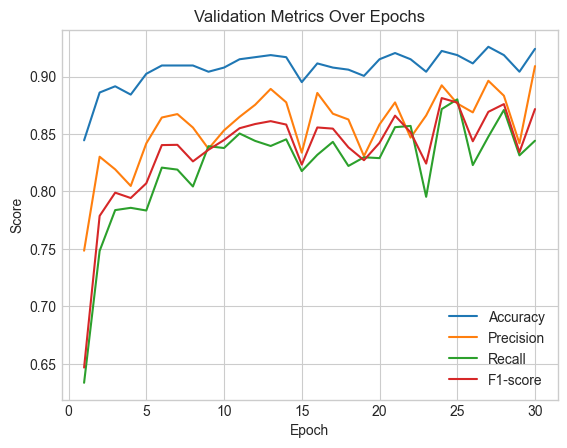

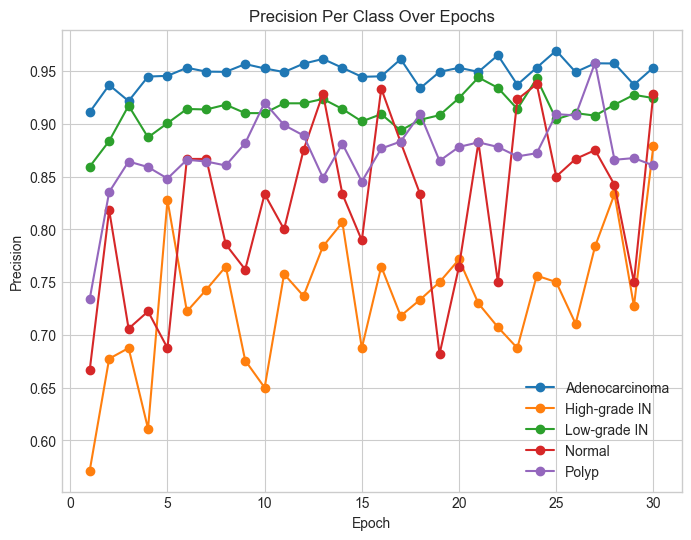

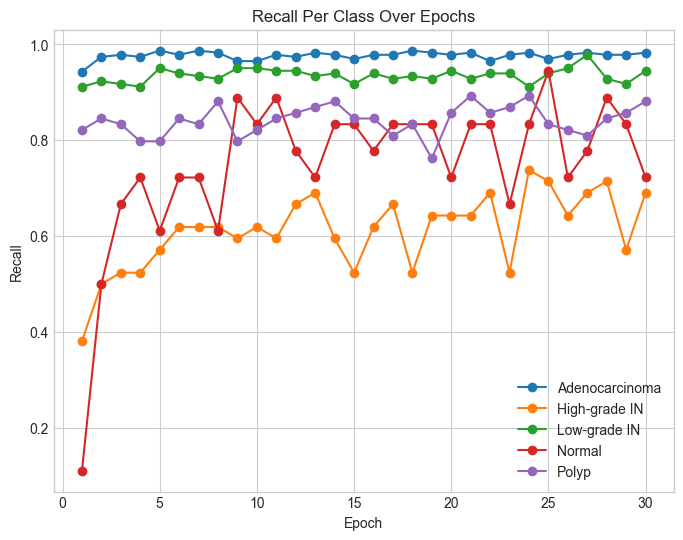

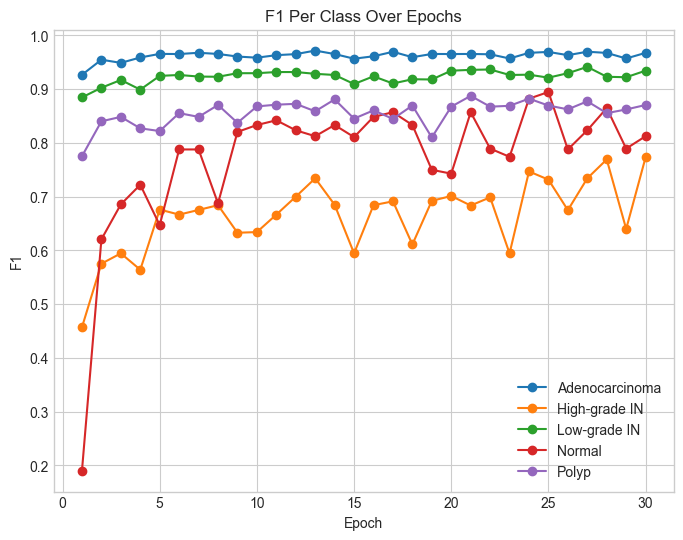

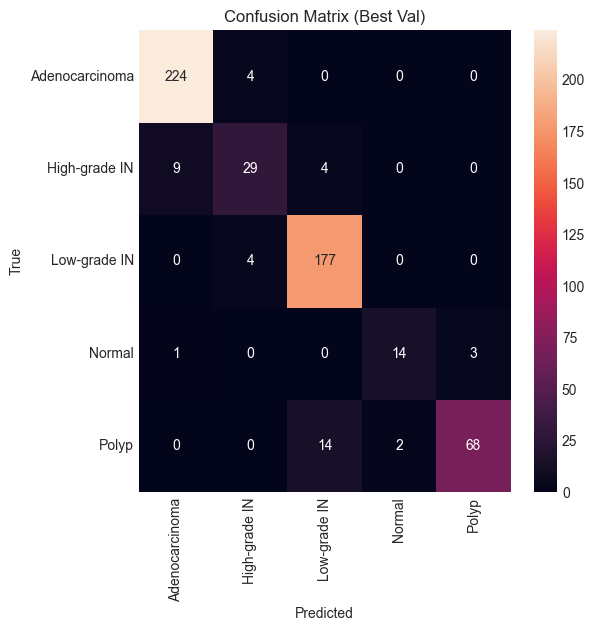

In [83]:
sys.argv = sys.argv[:1]
sys.argv += [
    "--data_dir", "datasetrebased",
    "--epochs", "30",
    "--batch_size", "32",
    "--lr", "1e-4",
    "--img_size", "256",
    "--optimizer", "adamw",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal+tversky",
    "--model", "efficientnet"  # ✅ Choose model dynamically
]
main()